In [49]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import pandas as pd

import matplotlib.animation as animation
import IPython

import torch.distributions as tdist

from ipywidgets import interact

from utils import *
from variational_inference_classes import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$\newcommand{\elbo}{\mathrm{ELBO}}$
$\newcommand{\kl}{\mathrm{KL}}$
$\newcommand{\set}[1]{ \left\{ #1 \right\}}$
$\def\R{{\mathbb R}}$
$\def\Q{{\mathbb Q}}$
$\def\E{{\mathbb E}}$
$\def\C{{\mathbb C}}$
$\def\N{{\mathbb N}}$
$\def\Z{{\mathbb Z}}$

$\newcommand{\brac}[1]{\left(#1\right)}$
$\newcommand{\abs}[1]{\left|\, #1\,\right|}$
$\newcommand{\p}{\partial}$
$\newcommand{\abrac}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\sqbrac}[1]{\left[ #1 \right]}$
$\newcommand{\st}{\, \, : \,}$
$\newcommand{\supp}{\mathrm{supp}}$
$\newcommand{\norm}[1]{\lVert #1 \rVert}$
$\renewcommand{\d}[1]{\, \mathrm{d}#1 \,}$

# Unit tests (Making sure that code works as intended)

## Unit test 1: Gaussian family VI to learn known Gaussian posterior
Will try to do variational inference against toy Gaussian posterior to make sure that the code has intended behaviour. 

We will attempt to approximate the normal distribution 
$$
p(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma_0^2I_d)}} e^{\frac{1}{2\sigma_0^2}\sum_{j = 1}^d (\xi_j - \mu_{0j})^2}. 
$$

We shall find a distribution from the following Gaussian family
$$
\mathcal{Q}_{gaussian} = \set{q_{\mu, \sigma}(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma^2I_d)}} e^{\frac{1}{2\sigma^2}\sum_{j = 1}^d (\xi_j - \mu_{j})^2} \st \mu \in \R^d, \sigma \in \R_{> 0}}
$$


In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{e^{-\frac{1}{2\sigma_0^2}\sum_j (\xi_j - \mu_{0j})^2}}} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

Epoch     0: mu=[0.56 0.02], sigma=[1.9638649225234985, 0.4620640277862549], elbo=-5.30
Epoch  1000: mu=[0.51 0.3 ], sigma=[1.0005227327346802, 1.2211271524429321], elbo=0.95
Epoch  2000: mu=[0.5 0.3], sigma=[0.7037582993507385, 2.5204386711120605], elbo=2.06
Epoch  3000: mu=[0.5 0.3], sigma=[0.5736253261566162, 2.996835708618164], elbo=2.24
Epoch  4000: mu=[0.5  0.29], sigma=[0.5198401212692261, 3.0049710273742676], elbo=2.24
Epoch  5000: mu=[0.5  0.31], sigma=[0.5025181770324707, 2.9957809448242188], elbo=2.24
Epoch  6000: mu=[0.5  0.31], sigma=[0.4998893141746521, 3.0200815200805664], elbo=2.24
Epoch  7000: mu=[0.5  0.29], sigma=[0.4988621473312378, 3.0060715675354004], elbo=2.24
Epoch  8000: mu=[0.5  0.29], sigma=[0.5014231204986572, 3.029527187347412], elbo=2.24
Epoch  9000: mu=[0.5  0.32], sigma=[0.49587225914001465, 3.0079965591430664], elbo=2.24


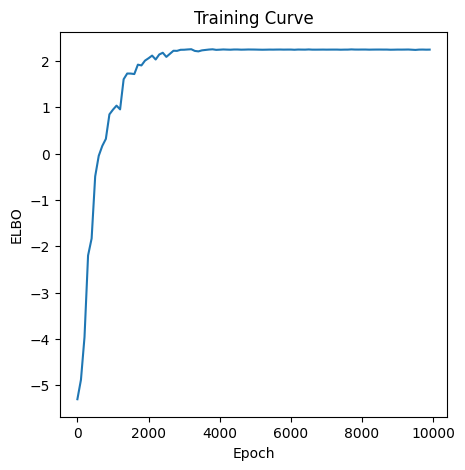

In [112]:
gaussian_vi = GaussianFamilyOn2DGaussianPosterior(
    mu_0=torch.tensor([0.5, 0.3]), 
    sigma_0=torch.tensor([0.5, 3.])
)
gaussian_vi.run_parameter_optimisation(10000)
fig = gaussian_vi.plot_training_curve();

In [113]:
fig, video = gaussian_vi.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))

## Unit test 2: Mean field generalised gamma family to learn mean field generalised gamma

Here we try to use a mean-field generalised gamma family to learn a known generalised gamma distribution: 
$$
p(\xi) = \prod_{j = 1}^2 \frac{\beta_{0j}^{\lambda_{0j}}}{\Gamma(\lambda_{0j})} \xi_j^{2k_{0j}\lambda_{0j} - 1} e^{-\beta_{0j}\xi_j^{2k_{0j}}}
$$

The mean-field generalised gamma variational family is given by
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\gamma(\lambda_j, \beta_j)\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}}
$$

In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{\prod_{j = 1}^2 \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} }} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

In [114]:
# TODO

# Standard Form
We are assuming that our posterior is of the form 
$$
p(\xi_1, \xi_2) = \frac{1}{\overline{Z}_n} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}, \quad (\xi_1, \xi_2) \in [0, 1]^2
$$
where $\overline{Z}_n = \int_{[0, 1]^2} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}} d\xi_1 d\xi_2$ is the normalising constant, a.k.a. the evidence.  

The posterior contours would look like the following:

In [46]:
N = 200
a, b = 0, 1
xx, yy = np.meshgrid(np.linspace(a, b, num=N), np.linspace(a, b, num=N))
w = np.stack((xx, yy), axis=-1)

@interact(
    n=(2, 100000),
    k1=(0, 10),
    k2=(0, 10),
    h1=(0, 10),
    h2=(0, 10)
)
def _plot_contour(n=500, k1=7, k2=5, h1=1, h2=3):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    h = np.array([h1, h2])
    k = np.array([k1, k2])
    boltzman_weight = lambda w: np.abs(np.prod(w**h, axis=-1)) * np.exp(-n * np.prod(w ** (2 * k), axis=-1))
    integrand = lambda y, x: boltzman_weight(np.array([x, y]))
    z = boltzman_weight(w)
    evidence = scipy.integrate.dblquad(integrand, 0, 1, 0, 1)

#     z = np.abs(np.prod(w**h, axis=-1)) * np.exp(-n * np.prod(w ** (2 * k), axis=-1))
    normalising_const = np.sum(z) / (N**2)
    lambdas = (h + 1) / (2 * k)
    rlct = np.min(lambdas)
    m = np.sum(lambdas == rlct)
    const_term = (
        scipy.special.loggamma(rlct) 
#         - np.log(scipy.special.factorial(m -1)) 
        - m * np.log(2)
    )
    
    if m == 2: 
        const_term -= np.sum(np.log(k))
    elif m == 1:
        i = np.argmin(lambdas)
        j = np.argmax(lambdas)
        const_term -= np.log(k[i])
        const_term -= np.log(lambdas[j] - lambdas[i])
    
    leading_terms = rlct * np.log(n) - (m -1) * np.log(np.log(n))
    print(
        f"evidence         = {evidence}\n"
        f"-logZ integrated = {-np.log(evidence[0])}\n"
        f"-logZ            = {-np.log(normalising_const)}\n"
        f"RLCT             = {rlct}\n"
        f"m                = {m}\n"
        f"const            = {const_term}\n"
        f"rlct log(n) - (m - 1) log log n         = {leading_terms}\n"
        f"rlct log(n) - (m - 1) log log n - log C = {leading_terms - const_term}\n"
        f"Residue          = {-np.log(evidence[0]) - leading_terms + const_term}\n"
    )
    ax.contourf(xx, yy, z / normalising_const, levels=100)
    ax.set_xlabel("$\\xi_1$")
    ax.set_ylabel("$\\xi_2$")

interactive(children=(IntSlider(value=500, description='n', max=100000, min=2), IntSlider(value=7, description…

Given a variational family $\mathcal{Q}$, we wish to find a variational approximation $\hat{q} \in \mathcal{Q}$ that minimises the KL-divergence $KL(\hat{q} || p(\xi_1, \xi_2)$. Notice though that this is equivalent to maximising the ELBO = Evidence Lower Bound: 
$$
\elbo(q)= -\E_q\sqbrac{n\xi^{2k}} - \E_q \log \frac{q(\xi)}{\xi^h} \\
$$

This can be shown by the following calculation. 
$$
\begin{align*}
  \kl(q||p) 
  &= \E_q\log \frac{q(\xi)}{p(\xi)}\\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}} \\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
\end{align*}
$$
Since $\kl(q||p) \geq 0$, we can bound the log-evidence with 
$$
  \log \overline{Z}_n \geq -\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} - \E_q n \xi_1^{2k_1} \xi_2^{2k_2} =: \elbo(q)
$$

# Experiment 1: Learning 2D standard form posterior 

## Experiment 1.0: Learning with Gaussian Family



We shall first use a simple Gaussian family of distribution for variational inference. 
$$
\mathcal{Q}_{gaussian} := \set{q_{\mu_1, \mu_2, \sigma}(\xi) = \frac{1}{2\pi \sigma^2} e^{-\frac{1}{2\sigma^2} \sqbrac{(\xi_1 - \mu_1)^2 + (\xi_2 - \mu_2)^2}} \st \mu_1, \mu_2 \in \R, \sigma \in (0, \infty)}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\begin{align*}
  -\nabla_\theta \elbo(q_\theta) 
  &= \nabla_\theta \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
  &= \nabla_\theta \E_q\log q(\xi) -  \E_q \log(\xi_1^{h_1} \xi_2^{h_2}) + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}
\end{align*}
$$

In [52]:
n = 10000
k_0 = torch.tensor([7., 3.])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1., 3.])
lambda_0 = (h_0 + 1) / (2 * k_0)
print(k_0)
print(h_0)
print(lambda_0)


gaussian_on_standard_form = GaussianFamilyOn2DStandardForm(
    n=500,
    k_0=k_0,
    h_0=h_0, 
    lr=0.001, 
    init_mu=torch.tensor([0.6, 0.9]),
    init_logsigma=torch.log(torch.tensor([0.1, 1]))
)

gaussian_on_standard_form.run_parameter_optimisation(5000)
fig = gaussian_on_standard_form.plot_training_curve();

tensor([7., 3.])
tensor([1., 3.])
tensor([0.1429, 0.6667])
Epoch      0: mu=[0.6 0.9], sigma=[0.09990005195140839, 0.9990004897117615], elbo=-166.57
Epoch    500: mu=[0.47 0.77], sigma=[0.08977281302213669, 0.8944727182388306], elbo=-9.00
Epoch   1000: mu=[0.43 0.78], sigma=[0.08739536255598068, 0.8642158508300781], elbo=-1.92
Epoch   1500: mu=[0.41 0.81], sigma=[0.08583835512399673, 0.8410861492156982], elbo=-2.11
Epoch   2000: mu=[0.4  0.81], sigma=[0.08499903976917267, 0.8400205969810486], elbo=-2.14
Epoch   2500: mu=[0.38 0.84], sigma=[0.08416704833507538, 0.82874995470047], elbo=-2.46
Epoch   3000: mu=[0.37 0.87], sigma=[0.08390896767377853, 0.8051401376724243], elbo=-1.44
Epoch   3500: mu=[0.36 0.88], sigma=[0.08404946327209473, 0.8093225955963135], elbo=-2.09
Epoch   4000: mu=[0.35 0.89], sigma=[0.08420972526073456, 0.8090685606002808], elbo=-2.03
Epoch   4500: mu=[0.35 0.9 ], sigma=[0.08458314090967178, 0.8209404945373535], elbo=-1.57


In [117]:
fig, video = gaussian_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


# Experiment 2: Learning 2D standard form with Gamma Mean Field Family

## Generalised Gamma Mean Field Family and its ELBO
Our variational family in this case is a mean field family of generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}, \xi \in [0, \infty)}
$$

The expression for ELBO is given by
$$
\begin{align*}
  - \elbo(q_\theta) 
  &= \E_q n \xi_1^{2k_{01}} \xi_2^{2k_{02}} + \E_q\log \frac{q(\xi)}{\xi_1^{h_{01}} \xi_2^{h_{02}}}\\
\end{align*}
$$

<p style="color:red;font-size:large">
    Warning: The above expression might not be correct due to the fact that the support of mean-field gamma density is larger than that of the standard form on $[0, 1]^2$
</p>

The first term is given by (with $d = 2$ below)
$$
\begin{align*}
\E_q n \xi_1^{2k_1} \xi_2^{2k_2}
&= n \prod_{j = 1}^d \int_0^\infty q_j(\xi_j) \xi_j^{2k_{0j}} d\xi_j\\
&= n \prod_{j = 1}^d \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} \int_0^\infty \xi_j^{2k_j \lambda_j +2k_{0j} -1} e^{-\beta_j \xi_j^{2k_j}} d\xi_j \\
&= n \prod_{j = 1}^d \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} \frac{1}{2k_j\beta_j^{\lambda_j + \frac{k_{0j}}{k_j}}}\Gamma\brac{\lambda_j + \frac{k_{0j}}{k_j}}\\
&= n \prod_{j = 1}^d \frac{1}{ \beta_j^{k_{0j} / k_j}}\frac{\Gamma\brac{\lambda_j + \frac{k_{0j}}{k_j}}}{\Gamma(\lambda_j)}
\end{align*}
$$

The second term is given by 
$$
\begin{align*}
\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}}
&= \sum_{j = 1}^d \int_0^\infty q_j(\xi_j) \log \frac{q(\xi_j)}{\xi_j^{2\lambda_{0j} k_{0j} -1}}d\xi_j\\
&= \sum_{j = 1}^d \int_0^\infty q_j(\xi_j) \log \frac{\frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}}}{\xi_j^{2\lambda_{0j} k_{0j} -1}}d\xi_j\\
&= \sum_{j = 1}^d \log\brac{\frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} } 
- \beta_j \int_0^\infty q(\xi_j) \xi_j^{2k_j} d\xi_j
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\int_0^\infty q_j(\xi_j) \log \xi_j d\xi_j\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda_j)
- \beta_j \frac{\beta_j^{\lambda_j}2k_j}{\Gamma(\lambda_j)} \frac{\Gamma(\lambda_j + 1)}{2k_j \beta_j^{\lambda_j + 1}}
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\int_0^\infty q_j(\xi_j) \log \xi_j d\xi_j\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda_j)
- \lambda_j
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\frac{1}{2k_j}\brac{\psi(\lambda_j) - \log \beta_j}\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda_j)
- \lambda_j
+ \brac{\lambda_j - \frac{k_{0j}}{k_j}\lambda_{0j}}\brac{\psi(\lambda_j) - \log \beta_j}. 
\end{align*}
$$

To evaluate $\E_{q_j}\log \xi_j$, we have use the following observation 
$$
\frac{d}{d\lambda}\Gamma(\lambda) = \int_0^\infty e^{-t} \frac{d}{d\lambda}t^{\lambda -1} dt = \int_0^\infty e^{-t} t^{\lambda -1} \log t dt
$$
and hence, using the substitution $t =\beta \xi^{2k}$
$$
\begin{align*}
\E_{q} \log \xi 
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\int_0^\infty e^{-\beta \xi^{2k}} \xi^{2\lambda k - 1} \log \xi d\xi\\
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\int_0^\infty e^{-t} \brac{\frac{t}{\beta}}^{\lambda - 1/(2k)} \log\brac{\frac{t}{\beta}}^{1/(2k)} \frac{t^{1/(2k) - 1}}{2k\beta^{1/(2k)}} dt\\
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\frac{1}{4k^2 \beta^\lambda}\int_0^\infty e^{-t} t^{\lambda -1} \brac{\log t - \log \beta}dt\\
&= \frac{1}{2k\Gamma(\lambda)}\brac{\int_0^\infty e^{-t} t^{\lambda -1} \log t dt - \log \beta \int_0^\infty e^{-t}t^{\lambda -1} dt}\\
&= \frac{1}{2k\Gamma(\lambda)}\brac{\Gamma'(\lambda) - \Gamma(\lambda)\log \beta }\\
&= \frac{1}{2k}\brac{\frac{\Gamma'(\lambda)}{\Gamma(\lambda)} - \log \beta}\\
&= \frac{1}{2k}\brac{\psi(\lambda) - \log \beta}\\
\end{align*}
$$


# Experiment 2.1: Optimising all parameters ($\lambda$, $k$, $\beta_2$)

Note: 
 * It seems like making $\beta$ really large in the above expression maximises the ELBO expression .. This might be a consequence of the fact that the vairational distribution is not absolutely continuous w.r.t. the posterior ...? 
 * But with $n$ large or $\beta$ large, the constribution outside of the unit cube shouldn't matter much ...? 
 
 
<p style="color:red;font-size:large">
    Warning: While the following run converges, it violates the variational lower bound
</p>

n        = 1000
lambda_0 = tensor([0.1400, 0.4000])
ks_0     = tensor([7, 5])
h_0      = tensor([1, 3])

logZ=-2.7502
Epoch     0: elbo=-2.77, lambdas=[0.14, 0.4], ks=[7.01, 5.01], betas=[1000.0, 1.0]
Epoch  1000: elbo=-0.63, lambdas=[0.34, 1.5], ks=[2.7, 1.15], betas=[1000.0, 0.3]
Epoch  2000: elbo=12.97, lambdas=[2.56, 7.38], ks=[0.35, 0.31], betas=[1000.0, 0.08]
Epoch  3000: elbo=49.95, lambdas=[16.72, 32.7], ks=[0.06, 0.13], betas=[1000.0, 0.02]
Epoch  4000: elbo=73.78, lambdas=[54.45, 98.22], ks=[0.03, 0.1], betas=[1000.0, 0.01]
Epoch  5000: elbo=76.10, lambdas=[61.41, 185.48], ks=[0.02, 0.11], betas=[1000.0, 0.01]
Epoch  6000: elbo=76.73, lambdas=[61.05, 285.12], ks=[0.02, 0.11], betas=[1000.0, 0.0]
Epoch  7000: elbo=76.95, lambdas=[60.85, 392.96], ks=[0.02, 0.12], betas=[1000.0, 0.0]
Epoch  8000: elbo=77.03, lambdas=[60.76, 495.96], ks=[0.02, 0.12], betas=[1000.0, 0.0]
Epoch  9000: elbo=77.05, lambdas=[60.71, 575.15], ks=[0.02, 0.12], betas=[1000.0, 0.0]


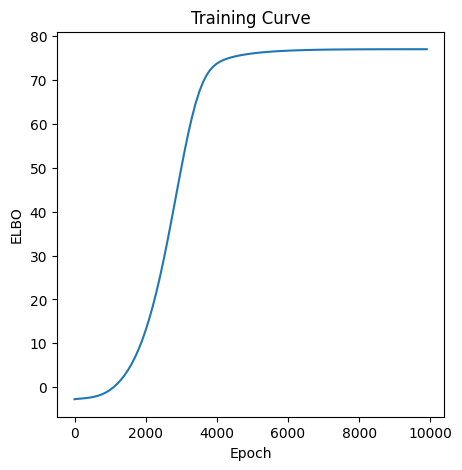

In [146]:
n = 1000
k_0 = torch.tensor([7, 5])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1, 3])
lambda_0 = (h_0 + 1) / (2 * k_0)

print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"h_0      = {np.around(h_0.detach(), 2)}\n"
)

mean_field_gamma_on_standard_form = MeanFieldGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lambdas_grad=True, 
    ks_grad=True, 
    beta1_grad=False,
)
print(f"logZ={mean_field_gamma_on_standard_form.log_evidence():.4f}")
mean_field_gamma_on_standard_form.run_parameter_optimisation(10000)
mean_field_gamma_on_standard_form.plot_training_curve();

/Users/elau1/Desktop/desingularised-variational-inference/variational-approximation-for-singular-models/notebooks/variational_inference_classes.py:127: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(xx, yy, z, levels=levels, colors="k", alpha=0.5)
/Users/elau1/Desktop/desingularised-variational-inference/variational-approximation-for-singular-models/notebooks/variational_inference_classes.py:148: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(xx, yy, z, levels=levels, colors="k", alpha=0.5)
/Users/elau1/.local/share/virtualenvs/variational-approximation-for-singular-mod-zs1nWu9R/lib/python3.10/site-packages/matplotlib/contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/elau1/.local/share/virtualenvs/variational-approximation-for-singular-mod-zs1nWu9R/lib/python3.10/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked

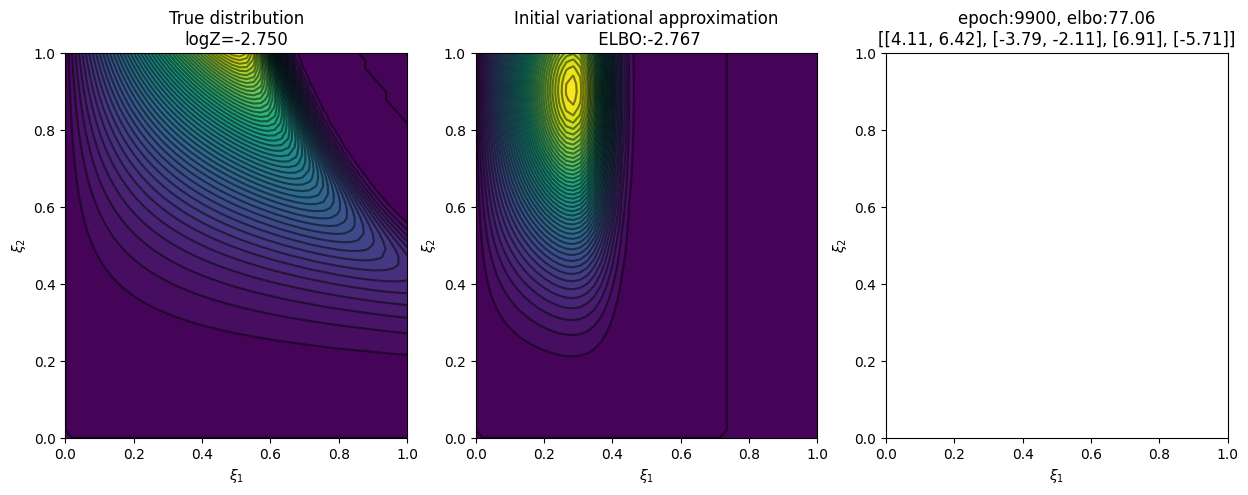

In [147]:
fig, video = mean_field_gamma_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


## Experiment 2.2: Optimising only $\beta_2$
<p style="color:red;font-size:large">
    Warning: While the following run converges, it violates the variational lower bound
</p>

Notes: 
 * It seems like even when the $\lambda$ and $k$ are freezed to the true value, the $\beta$ corresponding to the smallest $\lambda$ goes to $\infty$ while the other one goes to $0$. 

n        = 1000
lambda_0 = tensor([0.1400, 0.4000])
ks_0     = tensor([7, 5])
h_0      = tensor([1, 3])
logZ=-2.7502

Epoch     0: elbo=-2.77, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 1.0]
Epoch   800: elbo=-2.53, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.46]
Epoch  1600: elbo=-2.38, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.25]
Epoch  2400: elbo=-2.34, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.17]
Epoch  3200: elbo=-2.33, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.15]
Epoch  4000: elbo=-2.33, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.14]
Epoch  4800: elbo=-2.33, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.14]
Epoch  5600: elbo=-2.33, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.14]
Epoch  6400: elbo=-2.33, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.14]
Epoch  7200: elbo=-2.33, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.14]


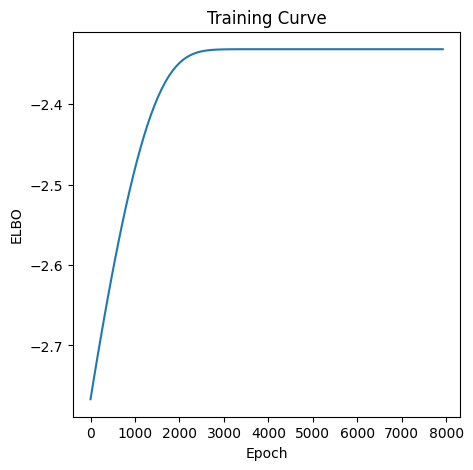

In [57]:
n = 1000
k_0 = torch.tensor([7, 5])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1, 3])
lambda_0 = (h_0 + 1) / (2 * k_0)

print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"h_0      = {np.around(h_0.detach(), 2)}"
)

meanfield_gamma_restricted_on_standard_form = MeanFieldGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lambdas_grad=False, 
    ks_grad=False, 
    beta1_grad=False,
)
print(f"logZ={meanfield_gamma_restricted_on_standard_form.log_evidence():.4f}\n")

meanfield_gamma_restricted_on_standard_form.run_parameter_optimisation(8000)
meanfield_gamma_restricted_on_standard_form.plot_training_curve();

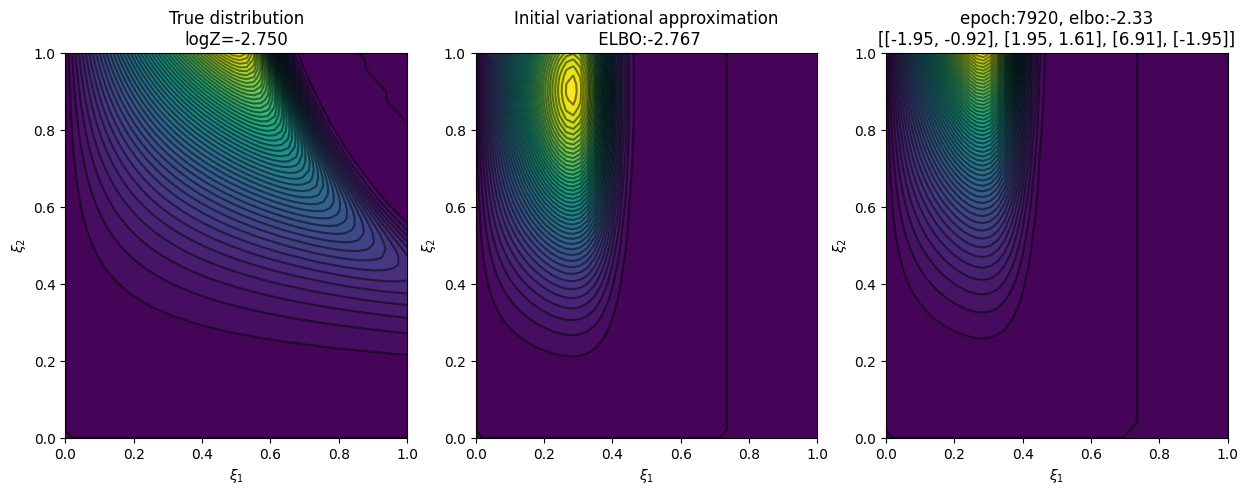

In [149]:
fig, video = meanfield_gamma_restricted_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


### Plotting saved snapshots 

In [155]:
N = 200
a, b = 0, 1
xx, yy = np.meshgrid(np.linspace(a, b, num=N), np.linspace(a, b, num=N))
w = np.stack((xx, yy), axis=-1)

@interact(
    snapshot_index=(0, len(meanfield_gamma_restricted_on_standard_form.snapshots) -1)
)
def _plot(snapshot_index=0):
    epoch, parameters, elbo = meanfield_gamma_restricted_on_standard_form.snapshots[snapshot_index]
    lambdas, ks, beta1, beta_rest = [
        torch.exp(param).detach() for param in parameters
    ]
    betas = torch.concat([beta1, beta_rest])
    print(f"Epoch: {epoch}, ELBO: {elbo.item():.3f}")
    print(lambdas, ks, betas)
    print(f"Mean coords: {2 * ks * (betas**lambdas) / torch.exp(torch.lgamma(lambdas))}")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    z = meanfield_gamma_restricted_on_standard_form.variational_density(
        torch.tensor(w), 
        [param.detach() for param in meanfield_gamma_restricted_on_standard_form.parameters]
    )

    ax.contourf(xx, yy, z, levels=100)
    ax.set_xlabel("$\\xi_1$")
    ax.set_ylabel("$\\xi_2$");

interactive(children=(IntSlider(value=0, description='snapshot_index'), Output()), _dom_classes=('widget-inter…

# Experiment 3: Learning 2D standard form with Truncated Generalised Gamma Mean Field Family
Our variational family in this case is a mean field family of truncated generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\gamma(\lambda_j, \beta_j)\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}, \xi \in [0, 1)}
$$

ELBO expression: 
<p style="color:red;font-size:large"> TODO </p>

## Experiment 3.1: Optimising only $\beta_2$

[Parameter containing:
tensor([-1.9459, -0.9163]), Parameter containing:
tensor([1.9459, 1.6094]), Parameter containing:
tensor([6.9078]), Parameter containing:
tensor([0.], requires_grad=True)]
n        = 1000
lambda_0 = tensor([0.1400, 0.4000])
ks_0     = tensor([7, 5])
logZ     = -2.750

Epoch     0: elbo=-3.06, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 1.0]
Epoch   800: elbo=-3.03, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.35]
Epoch  1600: elbo=-3.03, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.14]
Epoch  2400: elbo=-3.03, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.06]
Epoch  3200: elbo=-3.03, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.03]
Epoch  4000: elbo=-3.03, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.01]
Epoch  4800: elbo=-3.03, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.0]
Epoch  5600: elbo=-3.03, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.0]
Epoch  6400: elbo=-3.03, lambdas=[0.14, 0.4], ks=[7.0, 

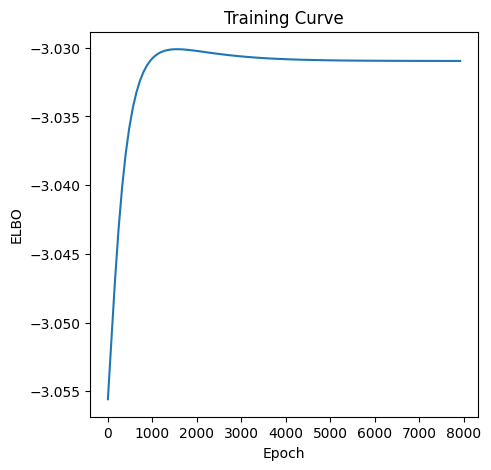

In [41]:
n = 1000
k_0 = torch.tensor([7, 5])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1, 3])
lambda_0 = (h_0 + 1) / (2 * k_0)


init_params = None
meanfield_truncated_gamma_restricted_on_standard_form = MeanFieldTruncatedGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lr=0.001, 
    lambdas_grad=False, 
    ks_grad=False, 
    beta1_grad=False, 
    init_params=init_params
)
print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"logZ     = {meanfield_truncated_gamma_restricted_on_standard_form.log_evidence():.3f}\n"
)


meanfield_truncated_gamma_restricted_on_standard_form.run_parameter_optimisation(8000)
fig = meanfield_truncated_gamma_restricted_on_standard_form.plot_training_curve();

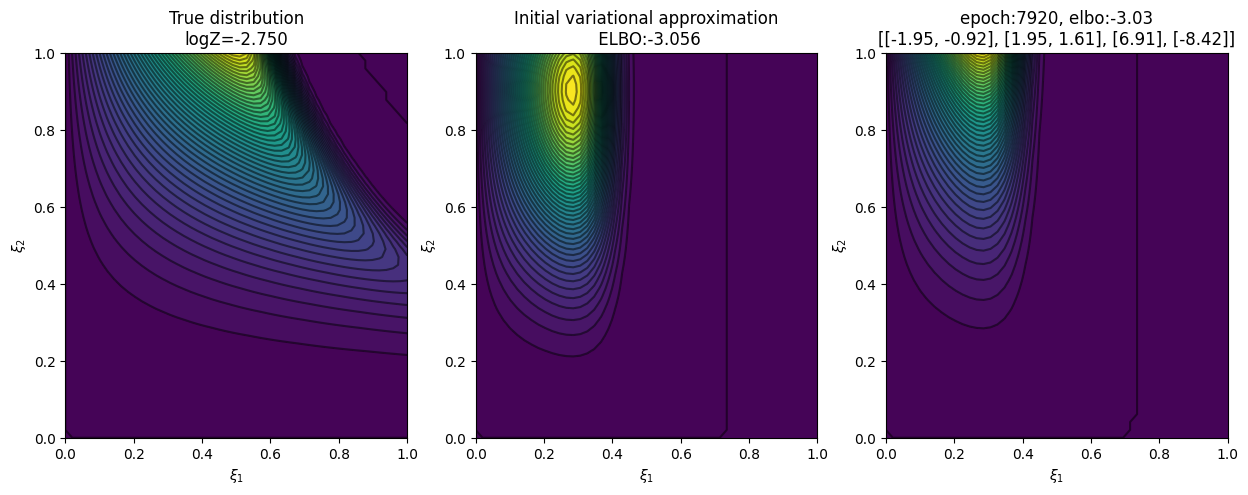

In [42]:
fig, video = meanfield_truncated_gamma_restricted_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


## Experiment 3.2: Optimising all $\lambda$, $k$, $\beta_2$

<p style="color:red;font-size:large"> 
    WARNING: `igamma` implementation seems to be numerically unstable so this will fail....
</p>

In [ ]:
n = 1000
k_0 = torch.tensor([7, 5])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1, 3])
lambda_0 = (h_0 + 1) / (2 * k_0)
# init_params = [
#     lambda_0 * 1.3, 
#     k_0 + 1, 
#     torch.tensor([n, 2])
# ]
init_params = None
meanfield_truncated_gamma_on_standard_form = MeanFieldTruncatedGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lr=0.001, 
    lambdas_grad=True, 
    ks_grad=True, 
    beta1_grad=False, 
    init_params=init_params
)
print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"logZ     = {meanfield_truncated_gamma_restricted_on_standard_form.log_evidence():.3f}\n"
)


meanfield_truncated_gamma_on_standard_form.run_parameter_optimisation(5000)
fig = meanfield_truncated_gamma_on_standard_form.plot_training_curve();

In [ ]:
fig, video = meanfield_truncated_gamma_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


# $n$-dependencies

In [50]:
from utils import logZ_approx

In [53]:
k_0 = torch.tensor([7, 5])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1, 3])
lambda_0 = (h_0 + 1) / (2 * k_0)

lr = 0.001
num_epoch = 5000
print(
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"h_0      = {np.around(h_0.detach(), 2)}\n"
#     f"logZ     = {meanfield_truncated_gamma_restricted_on_standard_form.log_evidence():.3f}\n"
)

rec = []
for logn in range(1, 12):
    n = int(10**logn)
    vis = dict(
        mf_gamma=MeanFieldGammaOn2DStandardForm(
            n=n,
            k_0=k_0,
            lambda_0=lambda_0,
            lr=lr, 
            lambdas_grad=False, 
            ks_grad=False, 
            beta1_grad=False,
        ), 
        mf_gamma_trunc=MeanFieldTruncatedGammaOn2DStandardForm(
            n=n,
            k_0=k_0,
            lambda_0=lambda_0, 
            lr=lr, 
            lambdas_grad=False, 
            ks_grad=False, 
            beta1_grad=False,
        ), 
        gaussian=GaussianFamilyOn2DStandardForm(
            n=n,
            k_0=k_0,
            h_0=h_0, 
            lr=lr, 
            init_mu=torch.tensor([0.6, 0.9]),
            init_logsigma=torch.log(torch.tensor([0.1, 1]))
        )
    )
    for vi_name, vi in vis.items():
        logZ = vi.log_evidence()
        leading_approx = logZ_approx(k_0.numpy(), h_0.numpy(), n)
        elbo_init = vi.elbo_fn().item()
        vi.run_parameter_optimisation(num_epoch, verbose=False)
        elbo = vi.elbo_fn().item()
        print(f"{vi_name:15s}, n={n:12d}, logZ={logZ:.4f} ({leading_approx:.4f}), "
              f"EBLO_0={elbo_init:.4f}, ELBO={elbo:.4f}")
        
        rec.append([vi_name, n, logZ, leading_approx, elbo_init, elbo])

lambda_0 = tensor([0.1400, 0.4000])
ks_0     = tensor([7, 5])
h_0      = tensor([1, 3])

mf_gamma       , n=          10, logZ=-2.2408 (0.2693), EBLO_0=-2.1090, ELBO=-1.6735
mf_gamma_trunc , n=          10, logZ=-2.2408 (0.2693), EBLO_0=-2.3977, ELBO=-2.3730
gaussian       , n=          10, logZ=-2.2408 (0.2693), EBLO_0=-175.2968, ELBO=-2.5338
mf_gamma       , n=         100, logZ=-2.4717 (-0.0596), EBLO_0=-2.4380, ELBO=-2.0025
mf_gamma_trunc , n=         100, logZ=-2.4717 (-0.0596), EBLO_0=-2.7266, ELBO=-2.7020
gaussian       , n=         100, logZ=-2.4717 (-0.0596), EBLO_0=-2144.6628, ELBO=-2.9181
mf_gamma       , n=        1000, logZ=-2.7502 (-0.3886), EBLO_0=-2.7669, ELBO=-2.3314
mf_gamma_trunc , n=        1000, logZ=-2.7502 (-0.3886), EBLO_0=-3.0556, ELBO=-3.0309
gaussian       , n=        1000, logZ=-2.7502 (-0.3886), EBLO_0=-2904.8938, ELBO=-110.1155
mf_gamma       , n=       10000, logZ=-3.0523 (-0.7175), EBLO_0=-3.0958, ELBO=-2.6603
mf_gamma_trunc , n=       10000, logZ=-3.052

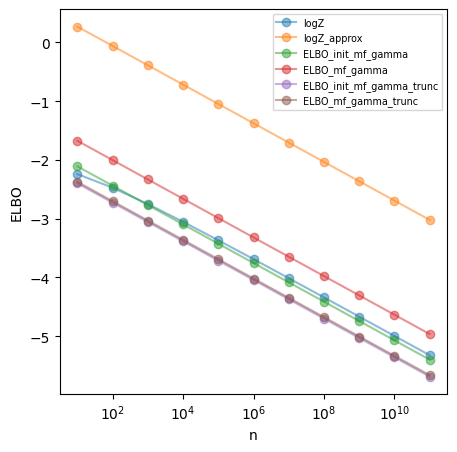

In [55]:
df = pd.DataFrame(rec, index=None)
df.columns = ["name", "n", "logZ", "logZ_approx", "ELBO_init", "ELBO"]
df = df.set_index("name")
fig,ax = plt.subplots(1, 1, figsize=(5, 5))
alpha=0.5
ax.plot(df.loc["mf_gamma", "n"], df.loc["mf_gamma", "logZ"], "o-", label="logZ", alpha=alpha)
ax.plot(df.loc["mf_gamma", "n"], df.loc["mf_gamma", "logZ_approx"], "o-", label="logZ_approx", alpha=alpha)

for name in df.index.unique():
    if name in ["gaussian"]:
        continue
    d = df.loc[name, :]
    ax.plot(df.loc[name, "n"], df.loc[name, "ELBO_init"], "o-", label=f"ELBO_init_{name}", alpha=alpha)
    ax.plot(df.loc[name, "n"], df.loc[name, "ELBO"], "o-", label=f"ELBO_{name}", alpha=alpha)
    
ax.set_xscale('log')
ax.set_xlabel("n")
ax.set_ylabel("ELBO")
ax.legend(fontsize="x-small")

# Experiment 4: Learning high dimension standard form, comparing Generalised Gamma Mean Field Family with Gaussian Family

# Misc

In [ ]:
f = lambda y, x: gaussian_on_standard_form.true_unnormalised_density(torch.tensor([x, y]))
scipy.integrate.dblquad(f, 0, 1, 0, 1)

In [ ]:

class CustomsFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, y):
        ctx.save_for_backward(x, y)
        return x**2 + 13 * y
    
    @staticmethod
    def backward(ctx, grad_output):
        x, y = ctx.saved_tensors
        return grad_output * 2 * x, grad_output * 13


In [ ]:
f = CustomsFunc.apply
x = torch.tensor(3., requires_grad=True)
y = torch.tensor(4., requires_grad=True)
z = f(x, y)
z.backward()

x.grad, y.grad

In [ ]:
x = torch.tensor(3., requires_grad=True)
y = torch.tensor(10., requires_grad=True)
z = igamma(x, y)
z.backward()
x.grad, y.grad

In [ ]:
@interact(
    n=(2, 10000), 
    t=(-2.0, 2.0)
)
def _plot_contour(n=50, t=0.5):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    x = np.linspace(-1, 1, num=1000)
    ax.plot(x, np.cos(2 * np.pi * n * (x**4 + t * x)) * (1 - np.exp(-1/x**2)), alpha=0.8)
    ax.plot(x, (1 - np.exp(-1/x**2)), color="r", alpha=0.5)
    ax.plot(x, -(1 - np.exp(-1/x**2)), color="r", alpha=0.5)

In [43]:
x1 = torch.tensor([1.0], requires_grad=False)
x2 = torch.tensor([2.0], requires_grad=True)

optim = torch.optim.Adam([x1, x2], lr=0.1)
for _ in range(10):
    optim.zero_grad()
    x = torch.stack([x1, x2], dim=-1)
#     a = x1**2 + x2**2
    a = torch.sum(x**2)
    a.backward()
    optim.step()
    print(a, x1, x2)

tensor(5., grad_fn=<SumBackward0>) tensor([1.]) tensor([1.9000], requires_grad=True)
tensor(4.6100, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.8002], requires_grad=True)
tensor(4.2406, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.7006], requires_grad=True)
tensor(3.8921, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.6015], requires_grad=True)
tensor(3.5648, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.5030], requires_grad=True)
tensor(3.2589, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.4051], requires_grad=True)
tensor(2.9744, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.3082], requires_grad=True)
tensor(2.7114, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.2123], requires_grad=True)
tensor(2.4698, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.1177], requires_grad=True)
tensor(2.2493, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.0246], requires_grad=True)


In [179]:

x1 = torch.tensor([10.000, 2.0, 3.2])
y1 = torch.tensor([6., 2.0, 1.0])
%time grad_lmbda_lower_incomplete_gamma(x1, y1)

CPU times: user 14 ms, sys: 39 µs, total: 14 ms
Wall time: 13.5 ms


tensor([ 4.8650e+04, -4.2873e-02, -5.5817e-02])

In [180]:
x = x1.numpy()
y = y1.numpy()
def integrand(t, x, y):
    return np.exp(-y * t) * (y * t)**(x-1) * np.log(y * t)
# integrand = lambda t, x, y: np.exp(-y * t) * (y * t)**(x-1) * np.log(y * t)

def f(x, y):
    return scipy.integrate.quad(integrand, 0, 1, args=(x, y))[0] * y

fvec = np.vectorize(f)
# vec_integrand = np.vectorize(integrand)
# %time scipy.integrate.quad(integrand, 0, 1)
%time fvec(x1, y1)

CPU times: user 866 µs, sys: 17 µs, total: 883 µs
Wall time: 889 µs


array([ 4.91165965e+04, -4.28732689e-02, -5.58167725e-02])

In [182]:
grad_lmbda_lower_incomplete_gamma(x1, y1)

tensor([ 4.8650e+04, -4.2873e-02, -5.5817e-02])

# Some Unit Tests

## Tests for $\gamma(\lambda, \beta)$
This is for (un-regularised) lower incomplete gamma function. 

Testing that as $\beta \to \infty$
$$
\frac{d}{d\lambda}\gamma(\lambda, \beta) \to \psi(\lambda)
$$

In [28]:
def gradgamma(lmbda, beta):
    # reference: Eq 25 for derivative of upper incomplete gamma in 
    # http://www.iaeng.org/IJAM/issues_v47/issue_3/IJAM_47_3_04.pdf
    acc = 0
    for k in range(50):
        term1 = torch.log(beta) / (lmbda + k)
        term1 -= 1 / (lmbda + k)**2
        
        logterm2 = (
            (k + lmbda) * torch.log(beta) - torch.lgamma(torch.tensor([k + 1], dtype=torch.float))
        )
        term2 = torch.exp(logterm2)
        if k % 2 == 1:
            term2 *= -1
        acc += term1 * term2
        
#         print(f"{k:3d}, {term1.item():.5f}, {term2.item():.5f}, {acc.item():.5f}, {(term1 * term2).item():.5f}")
    return acc

def _integrand(t, lmbda, beta, n):
    return np.exp(-beta * t) * (beta * t)**(lmbda-1) * np.log(beta * t)**n

def _integrated1(lmbda, beta):
    return scipy.integrate.quad(_integrand, 0, 1, args=(lmbda, beta, 1))[0] * beta

_vec_integrated = np.vectorize(_integrated1)

def gradgamma_int(lmbda, beta):
    return torch.tensor(_vec_integrated(lmbda, beta))



lmbda = torch.tensor([1., 1., 2., 2., 10., 10.])
beta = torch.tensor([5., 10., 5., 10., 5., 10.])
print(torch.digamma(lmbda))
x = gradgamma(lmbda, beta)
y = gradgamma_int(lmbda, beta)
print(x.tolist())
print(y.tolist())
print((x - y).tolist())

tensor([-0.5772, -0.5772,  0.4228,  0.4228,  2.2518,  2.2518])
[-0.589206874370575, -0.581569254398346, 0.3498516082763672, 0.40837812423706055, 16756.193359375, 4392482.0]
[-0.589208267845169, -0.5773243590717142, 0.34983224839485394, 0.42158486898258063, 16734.905289061047, 396770.57728189195]
[1.3934745940469284e-06, -0.004244895326631748, 1.9359881513247856e-05, -0.013206744745520083, 21.28807031395263, 3995711.422718108]


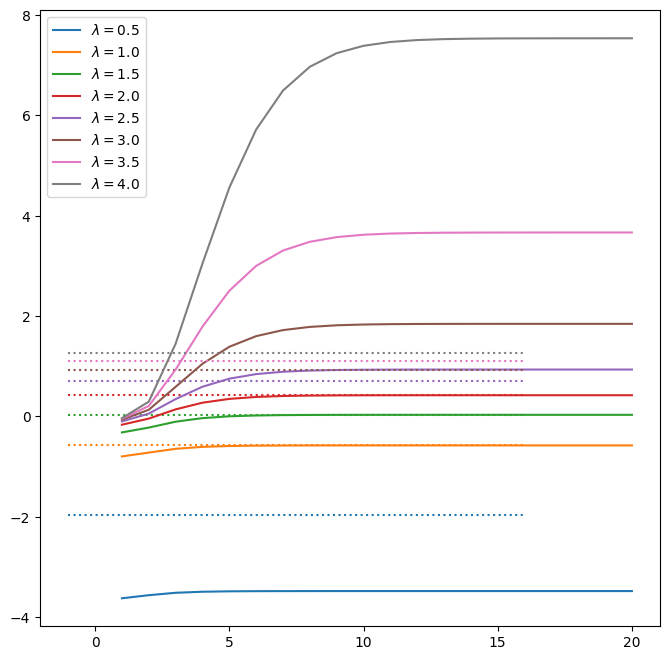

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
bs = torch.linspace(1, 20, steps=20)
for lmbda in [.5, 1., 1.5, 2.0, 2.5, 3.0, 3.5, 4.]:
    lmbda = torch.tensor([lmbda], dtype=torch.float)
    y = [gradgamma_int(lmbda, b) for b in bs]
    p = ax.plot(bs, y, label=f"$\\lambda={lmbda.item()}$")
    xmin, xmax = -1, 16
    ax.hlines([torch.digamma(lmbda).numpy()], xmin, xmax, linestyle="dotted", color=p[0].get_color())
    ax.legend()